In [76]:
## Import some utils
! pip install imageio -q
import matplotlib.pyplot as plt
import imageio
import os
import glob
import re
from datetime import datetime
import numpy as np
from tqdm.auto import trange, tqdm
import warnings

from matplotlib import rcParams

import colorsys
from matplotlib.colors import ColorConverter, LinearSegmentedColormap

rcParams.update({"xtick.major.pad": "7.0"})
rcParams.update({"xtick.major.size": "7.5"})
rcParams.update({"xtick.major.width": "1.5"})
rcParams.update({"xtick.minor.pad": "7.0"})
rcParams.update({"xtick.minor.size": "3.5"})
rcParams.update({"xtick.minor.width": "1.0"})
rcParams.update({"ytick.major.pad": "7.0"})
rcParams.update({"ytick.major.size": "7.5"})
rcParams.update({"ytick.major.width": "1.5"})
rcParams.update({"ytick.minor.pad": "7.0"})
rcParams.update({"ytick.minor.size": "3.5"})
rcParams.update({"ytick.minor.width": "1.0"})
rcParams.update({"font.size": 20})
rcParams.update({"xtick.top": True})
rcParams.update({"ytick.right": True})
rcParams.update({"xtick.direction": "in"})
rcParams.update({"ytick.direction": "in"})


def collect_runtimes(func, n_vals, n_trials=2, kwargs={}) -> np.ndarray:
    """
    Collect runtimes for a function with different input sizes

    Parameters
    ----------
    func : function
        Function to run
    n_vals : list
        List of input sizes
    n_trials : int, optional
        Number of trials to run, by default 2
    kwargs : dict, optional
        Keyword arguments to pass to func, by default {}

    Returns
    -------
    np.ndarray
        Array of runtimes with shape (len(n_vals), n_trials)
    """
    warnings.filterwarnings("error")
    runtimes = np.zeros((len(n_vals), n_trials))
    for npart_i in trange(len(n_vals), desc="Collecting runtimes"):
        for trial_i in range(n_trials):
            start = datetime.now()
            n = n_vals[npart_i]
            try:
                func(N=n, **kwargs)
                runtimes[npart_i, trial_i] = get_runtime(start)
            except RuntimeWarning:
                runtimes[npart_i, trial_i] = np.nan
    return runtimes


def get_runtime(start: datetime):
    return (datetime.now() - start).total_seconds()


def make_gif(im_regex, outname, duration=0.1):
    imgs = glob.glob(im_regex)
    imgs = sorted(imgs, key=lambda x: int(re.findall(r"\d+", x)[0]))
    frames = [imageio.imread_v2(f) for f in imgs]
    imageio.mimsave(outname, frames, duration=duration)
    for f in imgs:
        os.remove(f)


def remove_spines(ax):
    """Remove all spines and ticks from an axis"""
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])


def scale_color_brightness(color, scale_l=1.0):
    rgb = ColorConverter.to_rgb(color)
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s=s)


def make_colormap(color):
    rgb = [
        (i, scale_color_brightness(color, scale_l=i + 1)) for i in np.linspace(0, 1, 30)
    ]
    cmap = LinearSegmentedColormap.from_list(f"custom_{color}", colors=rgb, N=256)
    cmap = cmap.reversed()
    return cmap


IOStream.flush timed out
IOStream.flush timed out


# N-Body Simulation

Below we have a basic implementation of an N-body simulation. We will use this as a baseline to compare against a vectorized/Cupy/multiprocessing implementations.

There are two main functions:
- the `newtonian_acceleration(pos, mass, G, softening)` which calculates the acceleration of each particle due to the gravitational force from all other particles. This is the most computationally expensive part of the simulation.
- the `nbody_runner()` which runs the simulation for a given number of particles and time steps.

## Basic "Loop" Implementation


In [47]:
from datetime import datetime
from tqdm.auto import trange
from typing import List, Union
import numpy as np
import matplotlib.pyplot as plt
import os
import random

G = 1.0  # Gravitational Constant
OUTDIR = 'orbit_out/'


### Basic Lists ###
def newtonian_acceleration_basic(pos, mass, G, softening):
    # positions r = [x,y,z] for all particles
    x = [p[0] for p in pos]
    y = [p[1] for p in pos]
    z = [p[2] for p in pos]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = [[x[j] - x[i] for j in range(len(pos))] for i in range(len(pos))]
    dy = [[y[j] - y[i] for j in range(len(pos))] for i in range(len(pos))]
    dz = [[z[j] - z[i] for j in range(len(pos))] for i in range(len(pos))]

    # matrix that stores 1/r^3 for all particle pairwise particle separations
    inv_r3 = [
        [
            (dx[i][j] ** 2 + dy[i][j] ** 2 + dz[i][j] ** 2 + softening ** 2)
            for j in range(len(pos))
        ]
        for i in range(len(pos))
    ]
    for i in range(len(pos)):
        for j in range(len(pos)):
            if inv_r3[i][j] > 0:
                inv_r3[i][j] = inv_r3[i][j] ** (-1.5)

    ax = [G * sum(dx[i][j] * inv_r3[i][j] for j in range(len(pos))) * mass[i] for i in range(len(pos))]
    ay = [G * sum(dy[i][j] * inv_r3[i][j] for j in range(len(pos))) * mass[i] for i in range(len(pos))]
    az = [G * sum(dz[i][j] * inv_r3[i][j] for j in range(len(pos))) * mass[i] for i in range(len(pos))]

    # pack together the acceleration components
    a = [(ax[i], ay[i], az[i]) for i in range(len(pos))]

    return a


def nbody_runner_basic(
        N=5,
        tEnd=5.0,
        dt=0.01,
        softening=0.1,
        random_seed=17,
        max_runtime=5,
        verbose=True,
):
    """ N-body simulation """

    random.seed(random_seed)
    # Initialisation
    mass = [20.0 / N] * N  # total mass of particles is 20
    pos = [[random.random() for _ in range(3)] for _ in range(N)]  # randomly selected positions and velocities
    vel = [[random.random() for _ in range(3)] for _ in range(N)]
    t = 0
    Nt = int(np.ceil(tEnd / dt))
    runtime_start = datetime.now()
    vel_mean = [sum(m * v for m, v in zip(mass, v)) / sum(mass) for v in zip(*vel)]
    vel = [[v[i] - vel_mean[i] for i in range(3)] for v in vel]
    acc = newtonian_acceleration_basic(pos, mass, G, softening)
    pos_save = [[[0.0 for _ in range(3)] for _ in range(N)] for _ in range(Nt + 1)]
    for i in range(N):
        for j in range(3):
            pos_save[i][j][0] = pos[i][j]

    # Simulation loop
    for i in trange(Nt, disable=not verbose, desc="Running simulation"):
        vel = [[v[j] + acc[i][j] * dt / 2.0 for j in range(3)] for i, v in enumerate(vel)]
        pos = [[pos[i][j] + vel[i][j] * dt for j in range(3)] for i in range(N)]
        acc = newtonian_acceleration_basic(pos, mass, G, softening)
        vel = [[v[j] + acc[i][j] * dt / 2.0 for j in range(3)] for i, v in enumerate(vel)]
        t += dt
        for k in range(N):
            for j in range(3):
                pos_save[i][k][j] = pos[k][j]
        runtime = get_runtime(runtime_start)
        if runtime > max_runtime:
            warnings.warn(f"Runtime exceeded {max_runtime} seconds. Stopping simulation.")
            break

    pos_save = np.array(pos_save)
    pos_save = np.transpose(pos_save, (1, 2, 0))
    return pos_save


# test that this actually works
%timeit -r 1 -n 1 nbody_runner_basic(N=10, random_seed=4, verbose=False, tEnd=1)

25.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Lets make a plot/gif of the particle positions

In [26]:
def plot_particles(positions: Union[List, np.ndarray], n_time_total: int = 0, color='tab:blue'):
    """Plot the positions of particles in 2D

    Parameters
    ----------
    positions : Union[List, np.ndarray]
        List of positions of particles. Should be of shape (n_particles, {xyz}, n_time).
    n_time_total : int, optional
        Total number of time steps (used for plotting the trail), by default 0
    color : str, optional
        Color of the particles, by default 'tab:blue'
    """

    n_part, _, n_time = positions.shape
    if n_time_total == 0:
        n_time_total = n_time

    fig = plt.figure(figsize=(4, 4), dpi=80)
    ax = fig.gca()

    # plot the particle orbits
    idx_end = np.argmax(np.where(np.sum(positions, axis=(0, 1)) != 0)[0])
    idx_start = np.max([int(idx_end - 0.1 * n_time_total), 0])
    nidx = idx_end - idx_start

    max_size = 10
    ax.scatter(
        positions[:, 0, idx_end], positions[:, 1, idx_end],
        s=max_size, color=color, ec='k', lw=0.5
    )

    # plot the trail
    if nidx > 1:
        ms = np.geomspace(1e-4, max_size, nidx)
        # set ms < 0.05 to 0
        mask = ms < 0.05
        ms[mask] = 0

        # colors = np.array([make_colormap('tab:blue', 'white')(i) for i in np.linspace(0, 1, nidx)])
        ax.scatter(
            positions[:, 0, idx_start:idx_end], positions[:, 1, idx_start:idx_end],
            s=[ms] * n_part, zorder=-10,
            c=[ms] * n_part,
            cmap=make_colormap(color),

        )

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax = plt.gca()
    remove_spines(ax)
    ax.set_aspect('equal', 'box')
    # remove white border around figure
    fig.tight_layout(pad=0)
    return fig


def plot_particle_gif(pos, outdir, dur):
    os.makedirs(outdir, exist_ok=True)
    n_part, _, n_time = pos.shape
    for i in trange(10, n_time, 10, desc='Making gif'):
        fig = plot_particles(pos[:, :, 0:i], n_time_total=n_time, color='tab:blue')
        # add textbox in top left corner
        ax = plt.gca()
        ax.text(
            0.05, 0.95,
            f't={i:003d}', transform=ax.transAxes,
            fontsize=14, verticalalignment='top',
            fontstyle='italic',
            alpha=0.5,
        )
        fig.savefig(f'{outdir}/orbit_{i:003d}.png')
        plt.close(fig)
    make_gif(f'{outdir}/orbit_*.png', f'{outdir}/orbit.gif', duration=dur)
    print(f'Gif saved to {outdir}/orbit.gif')

In [29]:
positions = nbody_runner_basic(N=3, random_seed=1, tEnd=7)
plot_particle_gif(positions, outdir='out_basic', dur=2)

Running simulation:   0%|          | 0/700 [00:00<?, ?it/s]

Making gif:   0%|          | 0/70 [00:00<?, ?it/s]

Gif saved to out_basic/orbit.gif


![out_basic/orbit.gif](out_basic/orbit.gif)

## Numpy-Vectorized Implementation

Lets swap some loops in for some numpy vectorized statements.

```warning
I've left some unvectorized statements for you to optimize and try and vectorize yourself 😊.
```

In [64]:

def newtonian_acceleration_np(pos, mass, G, softening):
    # positions r = [x,y,z] for all particles
    x = pos[:, 0:1]
    y = pos[:, 1:2]
    z = pos[:, 2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations
    inv_r3 = (dx ** 2 + dy ** 2 + dz ** 2 + softening ** 2)
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0] ** (-1.5)

    # pack together the acceleration components
    return G * np.hstack((
        np.matmul(dx * inv_r3, mass),
        np.matmul(dy * inv_r3, mass),
        np.matmul(dz * inv_r3, mass)
    ))


def nbody_runner_np(
        N: int = 5,
        tEnd: float = 10.0,
        dt: float = 0.01,
        softening: float = 0.1,
        random_seed: int = 17,
        max_runtime: int = 5,
        verbose: bool = True,
):
    """ N-body simulation """

    # Initialisation
    np.random.seed(random_seed)
    mass = 20.0 * np.ones((N, 1)) / N  # total mass of particles is 20
    pos = np.random.randn(N, 3)  # randomly selected positions and velocities
    vel = np.random.randn(N, 3)
    t = 0
    Nt = int(np.ceil(tEnd / dt))
    runtime_start = datetime.now()
    vel -= np.mean(mass * vel, 0) / np.mean(mass)
    acc = newtonian_acceleration_np(pos, mass, G, softening)
    pos_save = np.zeros((N, 3, Nt + 1))
    pos_save[:, :, 0] = pos

    # Simulation loop
    for i in trange(Nt, desc="Running simulation", disable=not verbose):
        vel += acc * dt / 2.0
        pos += vel * dt
        acc = newtonian_acceleration_np(pos, mass, G, softening)
        vel += acc * dt / 2.0
        t += dt
        pos_save[:, :, i + 1] = pos
        runtime = get_runtime(runtime_start)
        if runtime > max_runtime:
            warnings.warn(f"Runtime exceeded {max_runtime} seconds. Stopping simulation.")
            break
    return pos_save


# test that this actually works
print("Vectorized time:")
%timeit -r 5 -n 5 nbody_runner_np(N=5, random_seed=4, verbose=False, tEnd=1)
print("Basic 'Loop' time:")
%timeit -r 5 -n 5 nbody_runner_basic(N=5, random_seed=4, verbose=False, tEnd=1)

Vectorized time:
10.9 ms ± 1.68 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
Basic 'Loop' time:
13.8 ms ± 4.81 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


## Runtime comparison
Lets make a plot of the runtime for different numbers of particles using the two different methods

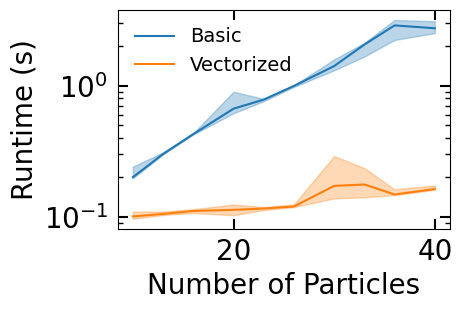

In [80]:
def plot_runtimes(n_particles, n_trials=3):
    kwargs = dict(verbose=False, max_runtime=5)
    vectorized = collect_runtimes(nbody_runner_np, n_particles, n_trials, kwargs=kwargs)
    basic = collect_runtimes(nbody_runner_basic, n_particles, n_trials, kwargs=kwargs)

    fig, ax = plt.subplots(figsize=(5,3.5))
    ax.set_yscale('log')
    for i, (data, label) in enumerate(zip([basic, vectorized], ['Basic', 'Vectorized'])):
        ax.plot(n_particles, np.quantile(data, 0.5, axis=1), label=label, color=f'C{i}')
        ax.fill_between(
            n_particles,
            np.quantile(data, 0.05, axis=1),
            np.quantile(data, 0.95, axis=1),
            alpha=0.3,
            color=f'C{i}',
        )
    ax.set_xlabel('Number of Particles')
    ax.set_ylabel('Runtime (s)')
    ax.legend(frameon=False, fontsize=14)
    plt.tight_layout()
    return fig


# Here n-trials is the number of times we repeat each simulation to get an average runtime
fig = plot_runtimes(n_particles=np.linspace(10, 40, 10,dtype=int), n_trials=4)
fig.savefig('nbody_runtimes.png')

![nbody_runtimes.png](nbody_runtimes.png)

Lets make a slightly longer gif with more particles using the vectorized implementation.

In [79]:
positions = nbody_runner_np(N=10, random_seed=1, tEnd=10)
plot_particle_gif(positions, outdir='out_nb_np', dur=3)

Running simulation:   0%|          | 0/1000 [00:00<?, ?it/s]

Making gif:   0%|          | 0/100 [00:00<?, ?it/s]

Gif saved to out_nb_np/orbit.gif


![out_nb_np/orbit.gif](out_nb_np/orbit.gif)

## Questions

1. What will happen to the speed of the vectorized implementation as the number of particles increases? Why?
2. What is the runtime complexity of the basic implementation? What about the vectorized implementation?
3. Can you think of any other ways to speed up the simulation? Plot the runtimes.
4. Can you make a `GPU` implementation using `cupy`? (feel free to paste the vectorized code in chatGPT and ask it for help).
**Bonus**:
5. Can you make a `GPU` implementation such that the simulation runs in `O(N)` time?

I'll release the answers after the workshop. (Please remind me if i dont lol)

Share your plots/code/cool GIFs down below (in the website version of this page)! 😄